#Set Up

In [ ]:
# Importing PyTorch and Torchvision libraries
import torch
import torchvision

# Printing the versions of PyTorch and Torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)

# Checking if CUDA (GPU support) is available on the system
print("CUDA is available:", torch.cuda.is_available())

# Importing sys module for executing system commands
import sys

# Installing OpenCV and Matplotlib using pip
!{sys.executable} -m pip install opencv-python matplotlib

# Installing the Segment Anything model from the repository using pip
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything-2.git'

# Creating a directory for storing model checkpoints
!mkdir -p ../checkpoints/

# Downloading the pre-trained SAM-2 model checkpoint into the checkpoints directory
!wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt

PyTorch version: 2.4.0+cu121
Torchvision version: 0.19.0+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything-2.git to /tmp/pip-req-build-11itqg5c
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything-2.git /tmp/pip-req-build-11itqg5c
  Resolved https://github.com/facebookresearch/segment-anything-2.git to commit 7e1596c0b6462eb1d1ba7e1492430fed95023598
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
--2024-09-07 11:17:08--  https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.10, 13.227.219.70, 13.227.219.59, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.219.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 897952466 (856M) [application/vnd.snesdev-page-table]

In [ ]:
import os
# Setting an environment variable to enable fallback to CPU for unsupported operations when using Apple MPS (Metal Performance Shaders)
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

# Importing NumPy library for numerical operations
import numpy as np

# Importing PyTorch for tensor operations
import torch

# Importing Matplotlib for plotting images and data
import matplotlib.pyplot as plt

# Importing the Image module from the Python Imaging Library (PIL) for image manipulation
from PIL import Image

# Importing OpenCV for image processing
import cv2

# Installing Gradio, a library for building web-based interfaces
!pip install gradio

# Importing Gradio for creating user interfaces
import gradio as gr

In [ ]:
# Select the device for computation (GPU, MPS, or CPU)
if torch.cuda.is_available():
    # If CUDA is available, use the GPU (CUDA)
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    # If MPS (Metal Performance Shaders) is available (on Apple Silicon), use MPS
    device = torch.device("mps")
else:
    # Otherwise, fall back to CPU
    device = torch.device("cpu")

# Print the selected device
print(f"using device: {device}")

# If the device is CUDA (NVIDIA GPU)
if device.type == "cuda":
    # Enable automatic casting to bfloat16 precision for faster computation
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()

    # If the GPU is from the Ampere architecture (major version 8 or higher), enable TensorFloat-32 (TF32) for better performance
    # This feature allows faster matrix multiplications with slightly reduced precision
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

# If the device is MPS (Apple GPU)
elif device.type == "mps":
    # Print a message warning about preliminary support for MPS in PyTorch, and possible performance or output differences
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


#Function to plot masks, keypoints, boxes, and skeletons

In [ ]:
# Function to display a mask on the image
def show_mask(mask, cls, ax, borders=True):
    # Set color based on class (cls). Class 1 uses yellow, otherwise cyan.
    if cls == 1.0:
        color = np.array([255/255, 255/255, 0/255, 0.3])  # Yellow with transparency
    else:
        color = np.array([0/255, 255/255, 255/255, 0.3])  # Cyan with transparency

    # Get height and width from the mask's dimensions
    h, w = mask.shape[-2:]

    # Convert mask to uint8 format for proper image processing
    mask = mask.astype(np.uint8)

    # Reshape the mask and color to create a colored mask image
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

    # If borders are enabled, find and draw contours around the mask
    if borders:
        import cv2
        # Find contours in the mask
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

        # Smooth contours by approximating polygons
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]

        # Draw the contours on the mask image
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2)

    # Display the mask on the given axis (ax)
    ax.imshow(mask_image)

# Function to display keypoints as points on the image
def show_points(coords, cls, ax, marker_size=20):
    # Convert coordinates to a NumPy array
    coords = np.array(coords)

    # Set color based on class (cls). Orange for class 1, magenta otherwise.
    if cls == 1.0:
        color = 'orange'
    else:
        color = 'magenta'

    # Loop through each point and plot it
    for pt in coords:
        x_coord = pt[0]
        y_coord = pt[1]

        # Only plot points with valid coordinates (greater than 0)
        if x_coord > 0 and y_coord > 0:
            ax.scatter(x_coord, y_coord, color=color, marker='o', s=marker_size, edgecolor='white', linewidth=1)

# Define the skeleton structure (connections between keypoints)
skeleton = [[0, 1], [0, 2], [0, 3], [3, 4], [4, 5], [5, 6], [4, 7], [4, 9], [7, 8], [9, 10], [6, 11], [6, 13], [11, 12], [13, 14]]

# Function to draw skeleton lines between keypoints
def show_skeletons(keypoints, ax, cls, color='orange', width=2):
    # Iterate through the skeleton connections
    for conn in skeleton:
        start_idx, end_idx = conn
        x_start, y_start = keypoints[start_idx]  # Get coordinates of the start keypoint
        x_end, y_end = keypoints[end_idx]  # Get coordinates of the end keypoint

        # Set color based on class (cls). Orange for class 1, magenta otherwise.
        if cls == 1.0:
            color = 'orange'
        else:
            color = 'magenta'

        # Plot line connecting the two keypoints only if their coordinates are valid
        if x_start > 0 and y_start > 0 and x_end > 0 and y_end > 0:
            ax.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=width)

# Function to display a bounding box on the image
def show_box(box, cls, ax):
    # Get the coordinates of the box (x0, y0, width, height)
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]

    # Set color based on class (cls). White for class 1, blue otherwise.
    if cls == 1.0:
        color = 'white'
    else:
        color = 'blue'

    # Draw the box as a rectangle on the image
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor=color, facecolor=(0, 0, 0, 0), lw=2))

# Function to save the mask, keypoints, and boxes on the image, and save the result as an image file
def save_masks(image, masks, scores, classes, points, boxes, borders=True):
    # Create the output directory ('content/outputs') if it doesn't already exist
    output_dir = "content/outputs"
    os.makedirs(output_dir, exist_ok=True)

    # Display the base image
    plt.imshow(image)

    # Loop through masks, scores, classes, points, and boxes, and draw each on the image
    for i, (mask, score, cls, point, box) in enumerate(zip(masks, scores, classes, points, boxes)):
        show_mask(mask, cls, plt.gca(), borders=borders)  # Show mask
        if points is not None:
            show_points(point, cls, plt.gca())  # Show points
            show_skeletons(point, plt.gca(), cls)  # Show skeleton
        if boxes is not None:
            show_box(box, cls, plt.gca())  # Show box

    plt.axis('off')  # Hide axis for a clean image

    # Save the resulting image in the 'content/outputs' directory
    img_file = os.path.join(output_dir, "output_image.png")
    plt.savefig(img_file, bbox_inches='tight', pad_inches=0)  # Save the figure
    plt.close()  # Close the plot to free up memory

    # Open and return the saved image
    img = Image.open(img_file)
    return img

#Apply SAM

##Create SAM predictor

In [ ]:
# Import required functions and classes from the SAM-2 model package
from sam2.build_sam import build_sam2  # Function to build the SAM-2 model
from sam2.sam2_image_predictor import SAM2ImagePredictor  # Class to handle image predictions with SAM-2

# Set the path to the pre-trained SAM-2 model checkpoint
sam2_checkpoint = "../checkpoints/sam2_hiera_large.pt"

# Specify the configuration file for the SAM-2 model architecture
model_cfg = "sam2_hiera_l.yaml"

# Build the SAM-2 model using the configuration and the checkpoint file
# 'device' specifies whether to load the model on CPU, CUDA, or MPS
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

# Create an image predictor object using the built SAM-2 model
predictor = SAM2ImagePredictor(sam2_model)


##Import the best model from YOLOv8

In [ ]:
# Install the 'ultralytics' library which contains YOLOv8 functionalities
!pip install ultralytics

# Import the YOLO class from the 'ultralytics' library
from ultralytics import YOLO

# Import Google's Colab 'drive' module to mount Google Drive
from google.colab import drive

# Mount Google Drive to access files stored in your Drive from the Colab environment
drive.mount('/content/drive')

# Load a pre-trained YOLOv8 model from the specified path in Google Drive
# "/content/drive/My Drive/best.pt" refers to the location where your trained YOLOv8 model weights are stored
yolo_model = YOLO("/content/drive/My Drive/best.pt")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Main function to recruit SAM


0: 384x512 1 W, 47.9ms
Speed: 2.3ms preprocess, 47.9ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 512)
Processing /content/drive/My Drive/marmoset-dlc-2021-05-07/labeled-data/reachingvideo1/img01961.png


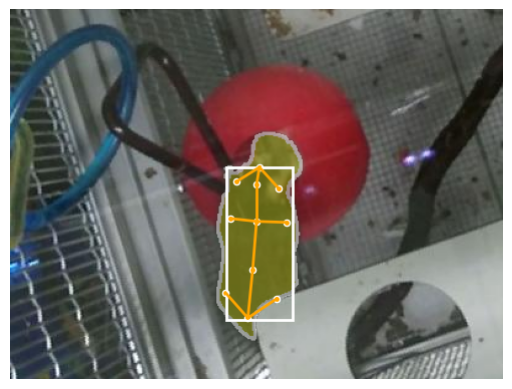


0: 512x512 1 B, 1 W, 30.5ms
Speed: 2.7ms preprocess, 30.5ms inference, 2.4ms postprocess per image at shape (1, 3, 512, 512)
Processing /content/drive/My Drive/marmoset-dlc-2021-05-07/labeled-data/reachingvideo1/img03064.png


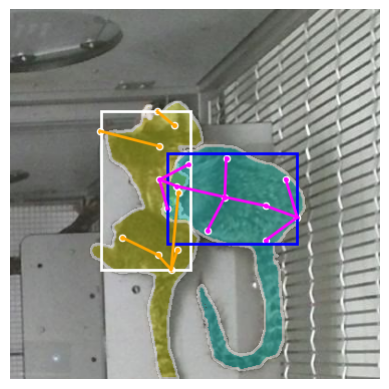


0: 512x512 1 W, 36.7ms
Speed: 2.9ms preprocess, 36.7ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 512)
Processing /content/drive/My Drive/marmoset-dlc-2021-05-07/labeled-data/reachingvideo1/img01693.png


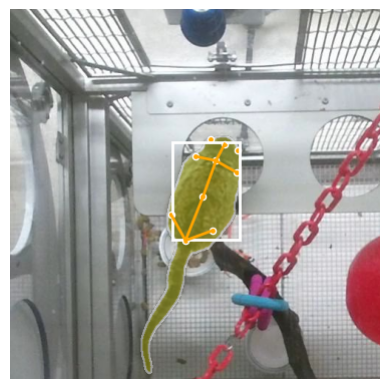


0: 512x512 1 B, 1 W, 34.6ms
Speed: 2.7ms preprocess, 34.6ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 512)
Processing /content/drive/My Drive/marmoset-dlc-2021-05-07/labeled-data/reachingvideo1/img06627.png


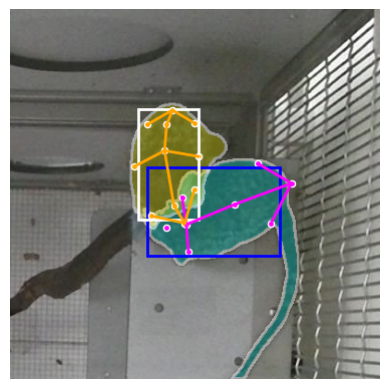


0: 512x512 1 B, 1 W, 36.0ms
Speed: 2.7ms preprocess, 36.0ms inference, 2.2ms postprocess per image at shape (1, 3, 512, 512)
Processing /content/drive/My Drive/marmoset-dlc-2021-05-07/labeled-data/reachingvideo1/img02357.png


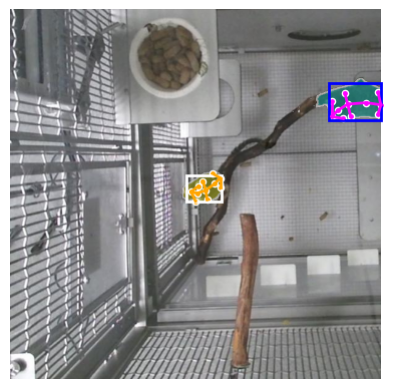

In [ ]:
# Function to segment images using YOLOv8 and SAM-2
def segment_images(image_list):
    # Loop through each image path in the provided list
    for image_path in image_list:
        # Run YOLOv8 model on the image
        results = yolo_model([image_path])
        result = results[0]
        print(f"Processing {image_path}")

        # Check if keypoints are detected in the YOLOv8 results
        if result.keypoints is not None and len(result.keypoints) > 0:
            # Move tensors (keypoints, boxes, classes) from GPU to CPU and convert to NumPy arrays
            keypoints = result.keypoints.xy.cpu().numpy()
            boxes = result.boxes.xyxy.cpu().numpy()  # Bounding boxes
            classes = result.boxes.cls.cpu().numpy()  # Class labels

            # Initialize lists to store masks and scores
            all_masks = []
            all_scores = []

            # Loop through each detection's keypoints, bounding box, and class
            for keypoint, box, cls in zip(keypoints, boxes, classes):
                points = []  # List to store valid keypoints for SAM-2

                # Filter keypoints to only include those inside the bounding box
                for kp in keypoint:
                    if kp[0] > 0.0 and kp[1] > 0.0:  # Ensure the keypoint is valid (non-zero)
                        if kp[0] < box[2] and kp[0] > box[0] and kp[1] > box[1] and kp[1] < box[3]:
                            points.append([kp[0], kp[1]])  # Append valid keypoint coordinates

                # Create labels for SAM-2 (all are '1' as they're valid points)
                labels = [1] * len(points)

                # Open the image using PIL and set it as input for the SAM-2 predictor
                image = Image.open(image_path)
                predictor.set_image(image)

                # Predict masks using SAM-2 with the given points
                masks, scores, logits = predictor.predict(
                    point_coords=points,  # Coordinates of the keypoints
                    point_labels=labels,  # Labels for the keypoints (1 = foreground)
                    multimask_output=True,  # Generate multiple mask outputs
                )

                # Sort the masks and scores based on scores in descending order
                sorted_ind = np.argsort(scores)[::-1]
                masks = masks[sorted_ind]
                scores = scores[sorted_ind]
                logits = logits[sorted_ind]

                # Select the best mask for further refinement
                mask_input = logits[np.argmax(scores), :, :]

                # Refine the best mask prediction using SAM-2
                masks, scores, logits = predictor.predict(
                    point_coords=points,  # Coordinates of the keypoints
                    point_labels=labels,  # Labels for the keypoints
                    mask_input=mask_input[None, :, :],  # Best mask from previous step
                    multimask_output=False,  # Produce a single refined mask
                )

                # Add the refined masks and scores to the list
                for (mask, score) in zip(masks, scores):
                    all_masks.append(mask)
                    all_scores.append(score)

            # Save and display the segmented image with masks, keypoints, and bounding boxes
            output_img = save_masks(image, all_masks, all_scores, classes, keypoints, boxes)

            # Display the output image using matplotlib
            plt.imshow(output_img)
            plt.axis('off')  # Turn off the axis display for clarity
            plt.show()
        else:
            print(f"No keypoints found for {image_path}")  # If no keypoints are detected, print this message

# List of image paths to process
images_dir = [
    '/content/drive/My Drive/marmoset-dlc-2021-05-07/labeled-data/reachingvideo1/img01961.png',
    '/content/drive/My Drive/marmoset-dlc-2021-05-07/labeled-data/reachingvideo1/img03064.png',
    '/content/drive/My Drive/marmoset-dlc-2021-05-07/labeled-data/reachingvideo1/img01693.png',
    '/content/drive/My Drive/marmoset-dlc-2021-05-07/labeled-data/reachingvideo1/img06627.png',
    '/content/drive/My Drive/marmoset-dlc-2021-05-07/labeled-data/reachingvideo1/img02357.png'
]

# Call the function to process and segment the images
segment_images(images_dir)


#Run Gradio for a Better User Interface

##Overlay only masks and skeletons on YOLOv8 images

In [ ]:
def show_mask_overlay(mask, cls, ax, borders=True):
    # Define color based on class
    color = np.array([255/255, 255/255, 0/255, 0.3]) if cls > 0.0 else np.array([0/255, 255/255, 255/255, 0.3])

    # Process the mask
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

    if borders:
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2)

    ax.imshow(mask_image)


In [ ]:
def show_skeletons_overlay(keypoints, ax, cls, color='orange', width=2):
    skeleton = [[0,1],[0,2],[0,3],[3,4],[4,5],[5,6],[4,7],[4,9],[7,8],[9,10],[6,11],[6,13],[11,12],[13,14]]
    for conn in skeleton:
        start_idx, end_idx = conn
        x_start, y_start = keypoints[start_idx]
        x_end, y_end = keypoints[end_idx]
        color = 'orange' if cls == 1.0 else 'magenta'
        if x_start > 0 and y_start > 0 and x_end > 0 and y_end > 0:
            ax.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=width)


In [ ]:
def overlay_masks(image, masks, scores, classes, points, boxes, borders=True):
    # Create 'content/outputs' directory if it doesn't exist
    output_dir = "content/outputs"
    os.makedirs(output_dir, exist_ok=True)

    # Plot the image and masks
    fig, ax = plt.subplots()
    ax.imshow(image)

    for i, (mask, score, cls, point, box) in enumerate(zip(masks, scores, classes, points, boxes)):
        show_mask_overlay(mask, cls, ax, borders=borders)
        if points is not None:
            show_skeletons_overlay(point, ax, cls)

    ax.axis('off')

    # Save the image in the 'content/outputs' directory
    img_file = os.path.join(output_dir, "output_image.png")
    plt.savefig(img_file, bbox_inches='tight', pad_inches=0)
    plt.close()  # Close the plot to free up memory

    # Load and return the saved image as PIL Image
    img = Image.open(img_file)
    return img


In [ ]:
def segment_images_gradio(image, result, yoloimage):
    # Check if keypoints are present in the results
    if result.keypoints is not None and len(result.keypoints) > 0:
        keypoints = result.keypoints.xy.cpu().numpy()
        boxes = result.boxes.xyxy.cpu().numpy()
        classes = result.boxes.cls.cpu().numpy()
        all_masks = []
        all_scores = []

        # Process each keypoint, box, and class
        for keypoint, box, cls in zip(keypoints, boxes, classes):
            points = [kp[:2] for kp in keypoint if kp[0] > 0.0 and kp[1] > 0.0 and box[0] < kp[0] < box[2] and box[1] < kp[1] < box[3]]
            labels = [1] * len(points)

            predictor.set_image(image)

            # Predict masks
            masks, scores, logits = predictor.predict(
                point_coords=points,
                point_labels=labels,
                multimask_output=True,
            )

            # Sort masks and scores by score
            sorted_ind = np.argsort(scores)[::-1]
            masks = masks[sorted_ind]
            scores = scores[sorted_ind]
            logits = logits[sorted_ind]

            # Select the best mask for further refinement
            mask_input = logits[np.argmax(scores), :, :]

            # Refine the mask
            masks, scores, logits = predictor.predict(
                point_coords=points,
                point_labels=labels,
                mask_input=mask_input[None, :, :],
                multimask_output=False,
            )

            # Append results
            for (mask, score) in zip(masks, scores):
                all_masks.append(mask)
                all_scores.append(score)

        # Overlay masks on YOLO image
        output_img = overlay_masks(yoloimage, all_masks, all_scores, classes, keypoints, boxes)
        return output_img
    else:
        return yoloimage


##Generate Gradio Interface

In [ ]:
# Define the function for prediction
def predict_image(img):
    # Run YOLO model predictions
    results = yolo_model.predict(
        source=img,
        show_labels=True,
        show_conf=True,
    )

    if results:
        # Get the YOLO prediction image and convert to RGB
        yolo_image = results[0].plot()
        yolo_image_rgb = cv2.cvtColor(yolo_image, cv2.COLOR_BGR2RGB)

        # Perform segmentation
        final_image = segment_images_gradio(img, results[0], yolo_image_rgb)

        return final_image  # Return as PIL image for Gradio display
    else:
        # Convert original image to PIL if no results
        return img  # Assuming img is already a PIL image

# Create Gradio interface
iface = gr.Interface(
    fn=predict_image,
    inputs=[
        gr.Image(type="pil", label="Upload Image")
    ],
    outputs=gr.Image(type="pil", label="Result"),  # Use gr.Image for PIL image output
    title="Ultralytics Gradio YOLOv8 plus Segment Anything Model (SAM)",
    description="Upload images for pose estimation and instance segmentation",
)

# Launch the Gradio interface
iface.launch()


##Example of the interface of Gradio

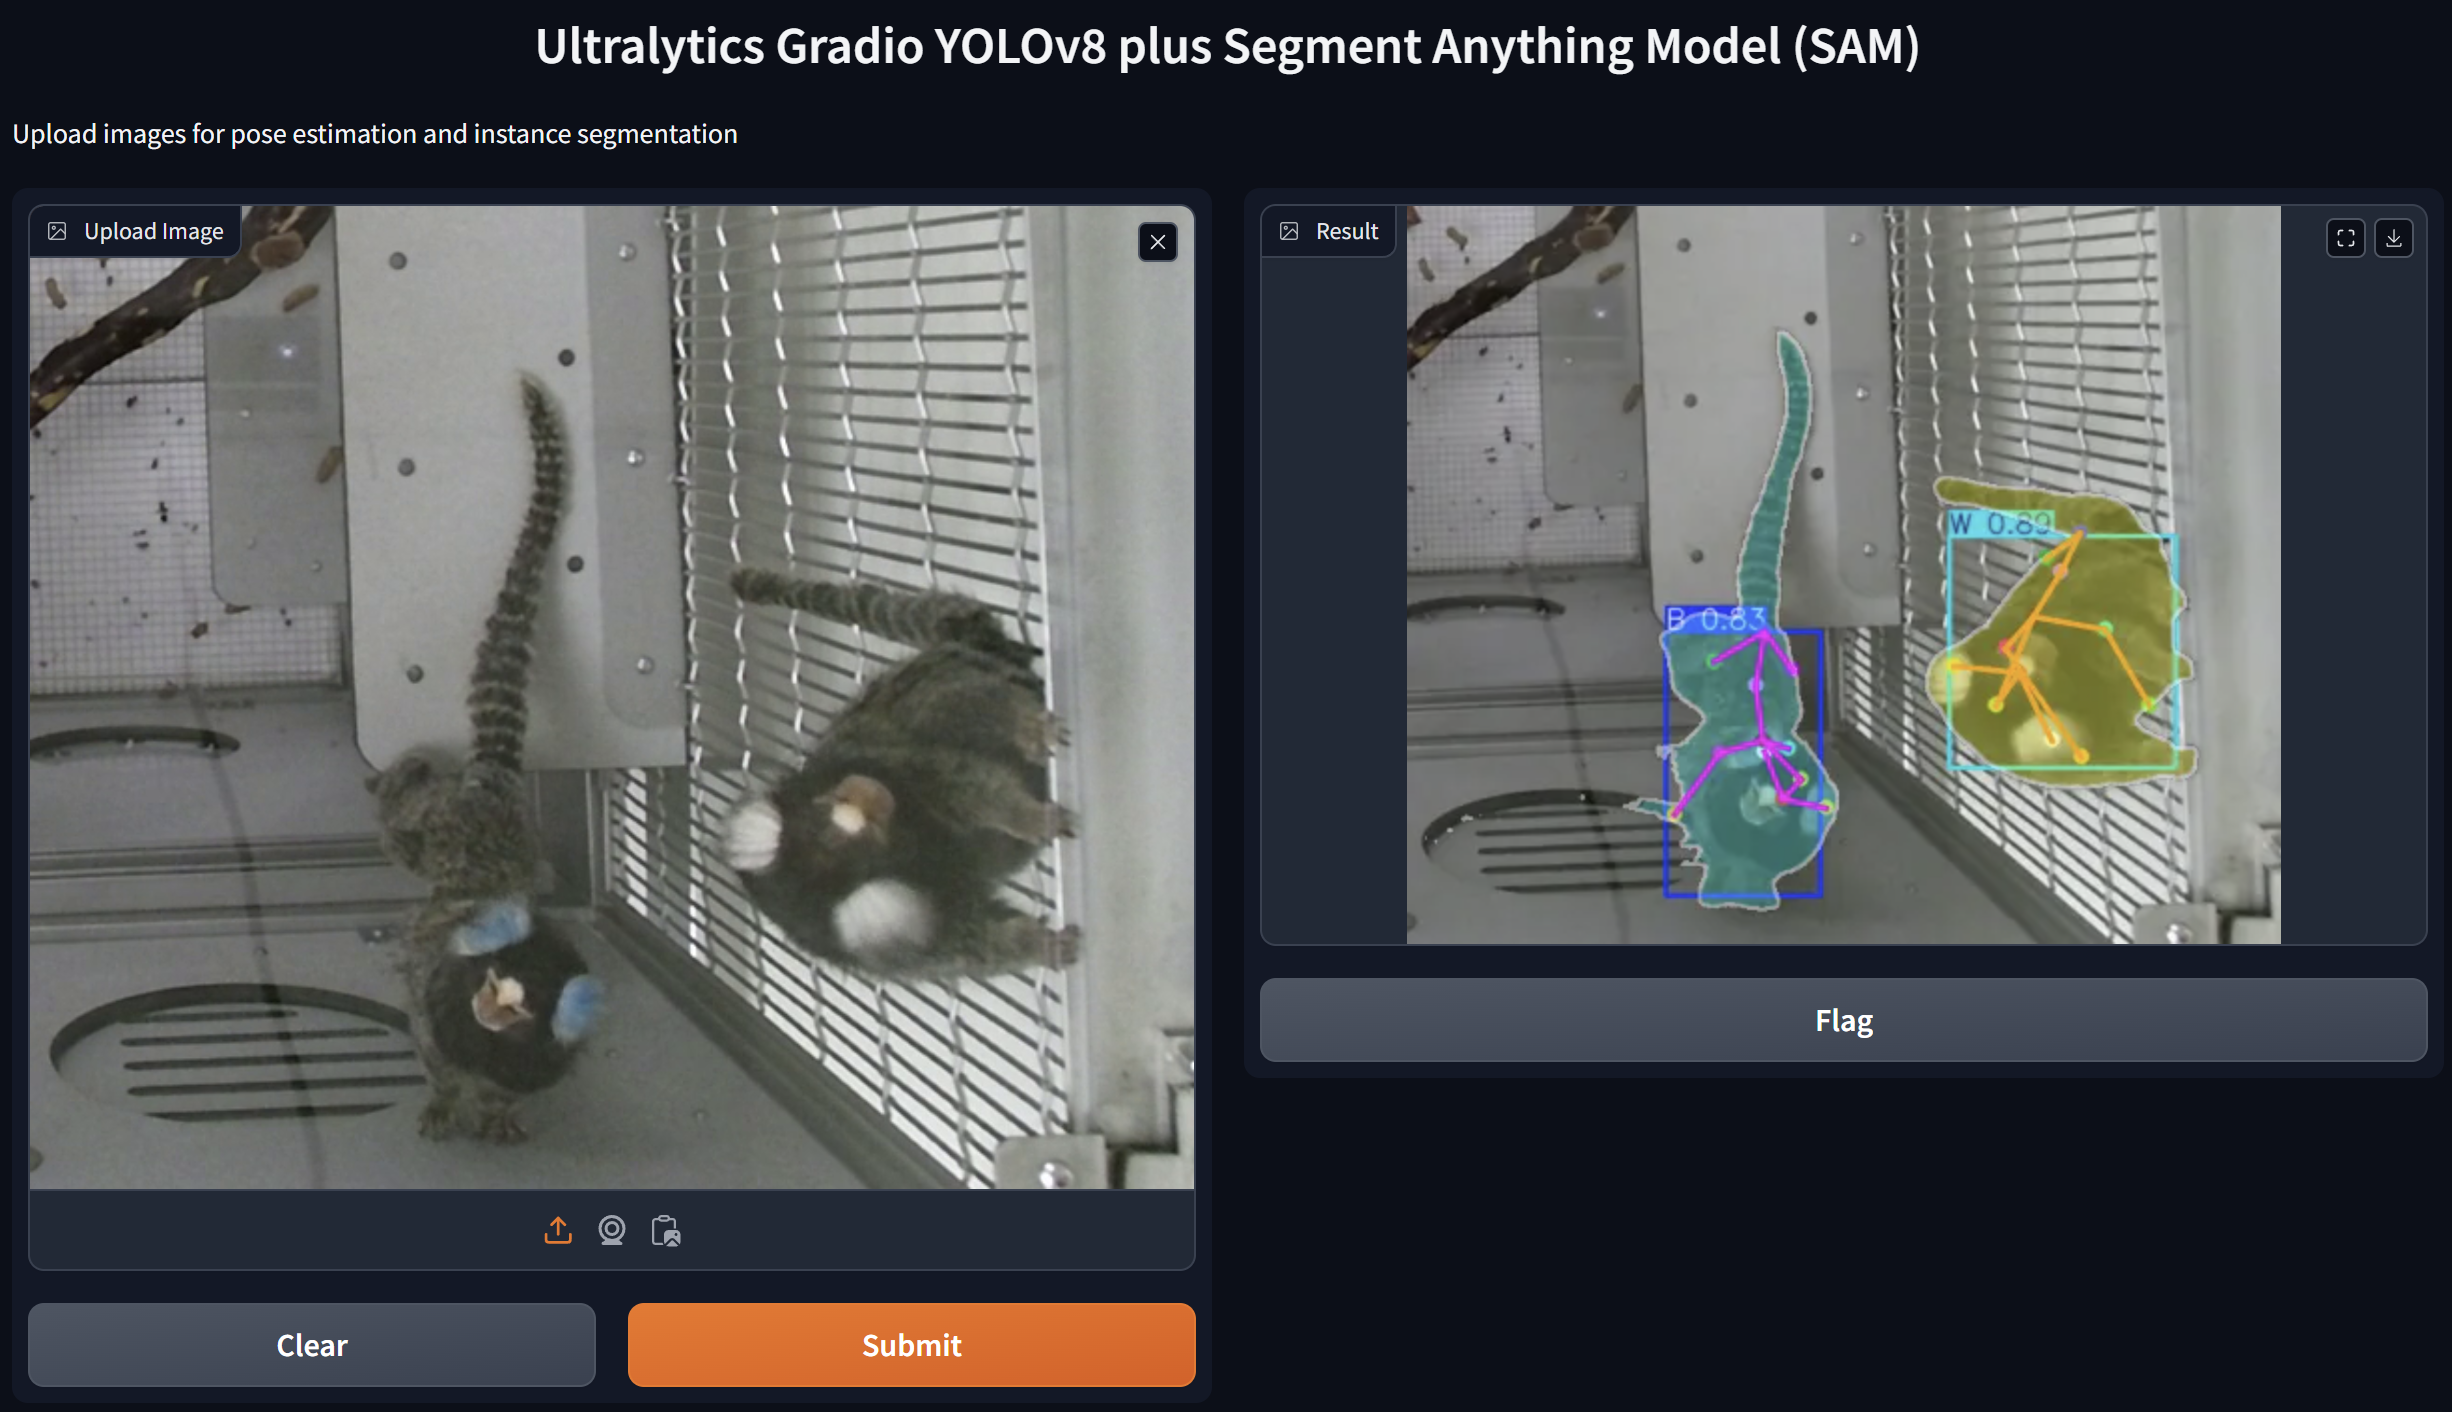